# Prepare and Plot MuSK Sequencing
- May 26, 2019
- Ruoyi Jiang
- R based pipeline for cloning together bait and bulk AIRR sequences, finding shared clones and plotting trees

# INPUTS

### Define input files

In [ ]:
meta_file <- "/data/AIRR_sample.csv"
tenx_meta_file <- "/data/SingleCell_sample.csv"

bulk_file <- "/data/bulk_unique.tab"
sanger_file <- "/data/MUSK_db-pass_germ-pass.tab"

### Define output files

In [ ]:
individual_thresholds_unique_file <- "/data/individual_thresholds_unique.csv"
thresholds_file <- "/data/thresholds.csv"

In [ ]:
dtn_tab_file <- "/data/db_unique_dtn.tab"
db_unique_total_file <- "/data/db_unique_total.tab"
db_unique_file <- "/data/db_unique.tab"
tree_toplot_file <- "/data/toplot.tab"
db_unique_overlap_file <- "/data/db_unique_total_overlap.tab"

### Define plot directory

In [140]:
PLOT_DIR <- "/data/plots"

dir.create(PLOT_DIR)

### Load libraries

In [138]:
library(dplyr)
library(alakazam)
library(shazam)
library(tidyr)
library(igraph)
library(stringi)
library(RColorBrewer)
library(VennDiagram)

source("/git/pipeline_abseq/api/saturn/saturn.R")

ref_dir <- "/usr/local/share/germlines/imgt/human/vdj"
DNAPARS_EXEC <- "/usr/local/bin/dnapars"

In [139]:
sessionInfo()

R version 3.6.1 (2019-07-05)
Platform: x86_64-redhat-linux-gnu (64-bit)
Running under: Fedora 31 (Workstation Edition)

Matrix products: default
BLAS/LAPACK: /usr/lib64/R/lib/libRblas.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] lazyeval_0.2.2      boot_1.3-22         VennDiagram_1.6.20 
 [4] futile.logger_1.4.3 RColorBrewer_1.1-2  igraph_1.2.5       
 [7] tidyr_1.1.0         shazam_0.2.1        stringi_1.4.6      
[10] alakazam_1.0.0      ggplot2_3.3.1       dplyr_1.0.0        

loaded via a namespace (and not attached):
 [1] Rc

# Create DF (2 mins)

### Load MetaData

In [143]:
META_DF <- read.csv(meta_file)

In [144]:
PATIENT_DICT <- META_DF %>% select(SAMPLE, PATIENT) %>% tibble::deframe()

In [145]:
RELAPSE_DICT <- META_DF %>% select(SAMPLE, RELAPSE) %>% tibble::deframe()

In [146]:
COLLECTION_DICT <- META_DF %>% select(SAMPLE, COLLECTION) %>% tibble::deframe()

Go through runs individually, see if the sample IDs are found and read in and set SOURCE, PATIENT, RELAPSE and COLLECTION fields

### Read in Bulk

In [291]:
DF_BULK <- readChangeoDb(bulk_file) %>%
    select(-X1) %>%
    rowwise() %>%
    mutate(
           COLLECTION = COLLECTION_DICT[SAMPLE],
           PATIENT = PATIENT_DICT[SAMPLE],
           RELAPSE = RELAPSE_DICT[SAMPLE],
           SOURCE = "Bulk",
           CREGION = translateStrings(CREGION, TRANS)
          ) 

Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Missing column names filled in: 'X1' [1]”

### Filter to only include Pre-RTX and Post-RTX

In [ ]:
DF_BULK <- DF_BULK %>%
    filter(RELAPSE %in% c("Pre-RTX", "Post-RTX"))

In [1]:
# DF_BULK %>%
#     group_by(RELAPSE, PATIENT) %>%
#     summarize(COUNT = length(SEQUENCE_IMGT))

### Read in Sanger

In [287]:
DF_SANGER <- readChangeoDb(sanger_file) %>%
    select(-X1) %>%
    rowwise() %>%
    mutate(POSITIVE = paste0(POSITIVE, "%"), MFI = paste0(MFI, " MFI")) %>%
    mutate(
           COLLECTION = COLLECTION_DICT[SAMPLE],
           PATIENT = PATIENT_DICT[SAMPLE],
           RELAPSE = RELAPSE_DICT[SAMPLE],
           CREGION = "Query",
           SOURCE = "Sanger"
          ) %>%
    drop_na(PATIENT) %>%
    filter(LOCUS == "HEAVY") 

Warning message:
“Missing column names filled in: 'X1' [1]”Warning message:
“Missing column names filled in: 'X1' [1]”

In [289]:
SANGER_ID_DICT <- DF_SANGER %>% select(SEQUENCE_ID, SANGER_ID) %>% tibble::deframe()

### Read in 10X

In [ ]:
SINGLE_CELL_DICT <- read.csv(tenx_meta_file) %>% 
    filter(LIBRARY == "BCR_VDJ", STATUS == "Post-RTX") %>%
    rowwise() %>%
    mutate(FILE = file.path(BASE_DIR, SAMPLE, "outs", "changeo", "filtered_contig_heavy_FUNCTIONAL-T.tab")) %>%
    select(SAMPLE_SIMPLE, FILE) %>% tibble::deframe()

In [ ]:
CREGION_DICT = c(
'IGHM' = "IgM",
'IGHD' = "IgD",
"IGHA1" = "IgA",
"IGHA2" = "IgA",
'IGHG1' = "IgG",
'IGHG2' = "IgG",
'IGHG3' = "IgG",
'IGHG4' = "IgG",
'IGHE' = "IgE"
)

In [ ]:
single_cell_list <- list()
for(sample in names(SINGLE_CELL_DICT)){
    single_cell_list[[sample]] <- readChangeoDb(SINGLE_CELL_DICT[sample]) %>%
    mutate(SAMPLE = sample) %>%
    rowwise() %>%
    mutate(
           COLLECTION = COLLECTION_DICT[SAMPLE],
           PATIENT = PATIENT_DICT[SAMPLE],
           RELAPSE = RELAPSE_DICT[SAMPLE],
           SOURCE = "10X",
           CREGION = CREGION_DICT[C_CALL]
          )
}

In [ ]:
DF_SINGLECELL <- bind_rows(single_cell_list)

### Merge DF

In [ ]:
DF_MERGE <- bind_rows(DF_BULK, DF_SANGER, DF_SINGLECELL)

In [304]:
dim(DF_MERGE)

[1] 949103     69

# Determine Threshold

### Find a threshold per patient (1 hr)

In [305]:
DF_MERGE %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())

Warning message:
“Grouping rowwise data frame strips rowwise nature”

PATIENT COUNT 
1 1       716266
2 2       104634
3 3       128203

In [25]:
PATIENT_THRESH_LIST <- list()

In [35]:
for(patient in unique(PATIENT_DICT)){
    cat(patient, '\n') 
    
    pt_thresh_df <- runShazam(pt_df, NPROC=parallel::detectCores(), SUBSAMPLE = 1000,
            plot_file = file.path(THRESH_DIR, paste(patient, "thresh.pdf", sep = '_')))
    
    pt_thresh_df$PATIENT <- patient
    
    PATIENT_THRESH_LIST[[patient]] <- pt_thresh_df
    
}

In [32]:
PATIENT_THRESH_DF <- bind_rows(PATIENT_THRESH_LIST)

In [33]:
PATIENT_THRESH_DF %>%
    group_by(PATIENT) %>%
    summarize(MEAN = mean(as.numeric(threshold)))

PATIENT MEAN      
1 1       0.12559397
2 2       0.09553291
3 3       0.15605869

Compute the mean of the individual thresholds

In [34]:
PATIENT_THRESH_DF %>%
    group_by(PATIENT) %>%
    summarize(MEAN = mean(as.numeric(threshold))) %>%
    summarize(MEAN = mean(MEAN))

MEAN     
1 0.1257285

In [36]:
PATIENT_THRESH_DF %>%
    write.csv(individual_threshold_unique_file)

### Find a threshold for all patients (2 hrs)

In [30]:
THRESH_DF <- runShazam(DF_MERGE, NPROC=parallel::detectCores(), SUBSAMPLE = 1000, 
                      plot_file = file.path(THRESH_DIR, paste("total", "thresh.pdf", sep = '_')))

In [31]:
THRESH_DF %>%
    write.csv(thresholds_file)

In [32]:
THRESH_DF %>%
    summarize(MEAN = mean(as.numeric(threshold)))

MEAN      
1 0.09028189

### CrossDTN for plotting the threshold choice

In [37]:
#Calculate DistToNearest using groupby and do
dtn_tab <- DF_MERGE %>%
    group_by(PATIENT) %>%
    do(distToNearest(., model="ham", first=FALSE, normalize="len", nproc=1)) %>%
    ungroup() %>%
    do(distToNearest(., model="ham", first=FALSE, normalize="len", cross="PATIENT", nproc=1))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [38]:
# generate density df

dtn_sum <- dtn_tab %>%
    group_by(PATIENT) %>%
    do(data.frame(DENSITY = hist(.$DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'DTN')

cross_sum <- dtn_tab %>%
    group_by(PATIENT) %>%
    do(data.frame(DENSITY = -1 * hist(.$CROSS_DIST_NEAREST, plot=FALSE, breaks=seq(0,1,by=0.02))$density)) %>%
    mutate(BINS = 1:n()/length(DENSITY), TYPE = 'CROSS')

toplot_df <- bind_rows(dtn_sum, cross_sum)

In [39]:
DTN_COLORS <- c(
'DTN' = '#636363',
'CROSS' = '#BDBDBD'
)

In [40]:
common_threshold <- read.csv(individual_threshold_unique_file) %>%
    group_by(PATIENT) %>%
    summarize(MEAN = mean(as.numeric(threshold))) %>%
    summarize(MEAN = mean(MEAN)) %>% select(MEAN) %>% unlist()

In [41]:
plot_list <- list()

for(patient in unique(dtn_tab$PATIENT)){
    
#     THRESHOLD <- thresh_df %>%
#         filter(PATIENT == patient) %>%
#         select(MEAN) %>% as.numeric()
    
    THRESHOLD <- common_threshold

    plot_list[[patient]] <- ggplot(filter(toplot_df, PATIENT == patient), 
             aes(x=BINS, y=DENSITY, fill=TYPE)) + 
        baseTheme() + 
        theme_bw() + 
        theme(legend.position="none") +
        xlab("Normalized hamming distance (Junction)") + 
        ylab("Density") +
        ggtitle(paste("Patient", patient)) +
        geom_bar(stat = "identity") +
        geom_vline(xintercept=THRESHOLD, color="firebrick", linetype=2) +
        scale_x_continuous(limits=c(0,0.75)) +
        scale_y_continuous(labels=abs) +
        scale_color_manual(values=DTN_COLORS) +
        scale_fill_manual(values=DTN_COLORS)
        #facet_grid(. ~ SUBJECT) +
        #facet_wrap(~ Sample, ncol=4, scales = "free_y")
    
}

Warning message:
“Removed 26 rows containing missing values (position_stack).”Warning message:
“Removed 26 rows containing missing values (position_stack).”

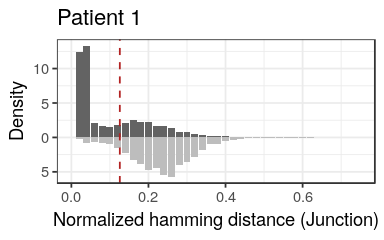

Warning message:
“Removed 26 rows containing missing values (position_stack).”

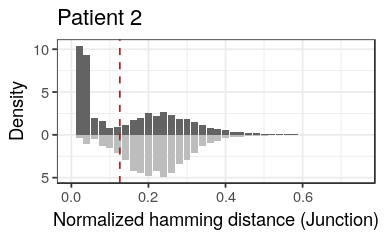

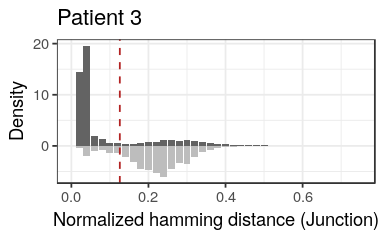

In [42]:
options(repr.plot.width=3.2, repr.plot.height=2)


for(patient in unique(dtn_tab$PATIENT)){
#     pdf(file.path(PLOT_DIR, paste0(patient, "_dtn.pdf")), 3.2, 2)
#     plot(plot_list[[patient]])
#     dev.off()
    
#     svg(file.path(PLOT_DIR, paste0(patient, "_dtn.svg")), 3.2, 2)
#     plot(plot_list[[patient]])
#     dev.off()
    plot(plot_list[[patient]])
}

In [46]:
writeChangeoDb(dtn_tab, dtn_tab_file)

In [291]:
#dtn_tab <- readChangeoDb("/home/ruoyi/kleinstein/projects/oconnor_musk/analysis/db_unique_dtn.tab")

# Clone and Germline (with groupby patient re-enabled) (5 hrs)

In [12]:
# read in the threshold
common_threshold <- read.csv(individual_thresholds_unique_file) %>%
    group_by(PATIENT) %>%
    summarize(MEAN = mean(as.numeric(threshold))) %>%
    summarize(MEAN = mean(MEAN)) %>% select(MEAN) %>% unlist()

In [13]:
common_threshold

MEAN 
0.1257285

In [309]:
# DefineClones (9 hrs)
DF_GERM_MERGE_TOTAL <- DF_MERGE %>%
    group_by(PATIENT) %>%
    do(runDefineClones(., clone_threshold = common_threshold))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [310]:
# CreateGermlines (3 hrs)
DF_GERM_MERGE_TOTAL <- DF_GERM_MERGE_TOTAL %>%
    group_by(PATIENT) %>%
    do(runCreateGermlines(.,ref_dir = ref_dir))

In [311]:
# observedMutations
DF_GERM_MERGE_TOTAL  <- DF_GERM_MERGE_TOTAL %>%
    ungroup() %>%
    observedMutations(frequency=TRUE) %>%
    mutate(MU_FREQ = MU_FREQ_SEQ_R + MU_FREQ_SEQ_S)

In [334]:
dim(DF_GERM_MERGE_TOTAL)

[1] 935566     76

In [313]:
DF_GERM_MERGE_TOTAL <- DF_GERM_MERGE_TOTAL %>%
    rowwise() %>%
    mutate(SANGER_ID = if(SOURCE == "Sanger"){SANGER_ID_DICT[SEQUENCE_ID]}else{""})

In [314]:
DF_GERM_MERGE_TOTAL %>%
    writeChangeoDb(db_unique_total_file)

# Filter for processing and final analysis

In [25]:
# Published sets only for Sanger analysis
set_selection <- c("JCI", "TK_PUB")

# Also create a PATIENT_CLONE identifier (useful for later calculations)
DF_GERM_MERGE <- DF_GERM_MERGE_TOTAL %>%
    filter(SOURCE %in% c("10X", "Bulk") | SET %in% set_selection) %>%
    rowwise() %>%
    mutate(PATIENT_CLONE = paste(PATIENT, CLONE, sep = ','))

In [27]:
# Filter FUNCTIONAL and absent CREGION calls
DF_GERM_MERGE <- DF_GERM_MERGE %>%
    filter(FUNCTIONAL)

In [28]:
DF_GERM_MERGE <- DF_GERM_MERGE %>%
    filter(CREGION != 'False')

In [29]:
# Define persistent labels
DF_GERM_MERGE <- DF_GERM_MERGE %>% 
    group_by(SEQUENCE_IMGT, PATIENT) %>%
    mutate(PERSISTENT_SEQUENCE = length(unique(RELAPSE)) > 1) %>% ungroup()

DF_GERM_MERGE  <- DF_GERM_MERGE  %>% 
    group_by(CLONE, PATIENT) %>%
    mutate(PERSISTENT_CLONE = length(unique(RELAPSE)) > 1) %>% ungroup()

DF_GERM_MERGE  <- DF_GERM_MERGE  %>% 
    group_by(CLONE, PATIENT) %>%
    mutate(EXPANDED_CLONE = (length(unique(SOURCE)) > 1) & !any(RELAPSE == "Pre-RTX")) %>% 
    ungroup()

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [30]:
DF_GERM_MERGE %>%
    writeChangeoDb(db_unique_file)

In [33]:
dim(DF_GERM_MERGE)

[1] 839731     82

# Read-in for final analysis

In [64]:
#DF_GERM_MERGE <- readChangeoDb("/home/ruoyi/kleinstein/projects/oconnor_musk/analysis/db_unique.tab") 

Warning message:
“48764 parsing failures.
   row     col           expected             actual                                                                  file
829940 CELL    1/0/T/F/TRUE/FALSE TAGCCGGTCAAGAAGT-1 '/home/ruoyi/kleinstein/projects/oconnor_musk/analysis/db_unique.tab'
829940 V_CIGAR 1/0/T/F/TRUE/FALSE 141S296=           '/home/ruoyi/kleinstein/projects/oconnor_musk/analysis/db_unique.tab'
829940 D_CIGAR 1/0/T/F/TRUE/FALSE 440S10N11=         '/home/ruoyi/kleinstein/projects/oconnor_musk/analysis/db_unique.tab'
829940 J_CIGAR 1/0/T/F/TRUE/FALSE 458S7N55=          '/home/ruoyi/kleinstein/projects/oconnor_musk/analysis/db_unique.tab'
829940 C_CALL  1/0/T/F/TRUE/FALSE IGHM               '/home/ruoyi/kleinstein/projects/oconnor_musk/analysis/db_unique.tab'
...... ....... .................. .................. .....................................................................
See problems(...) for more details.
”

In [65]:
DF <- DF_GERM_MERGE %>%
    filter(SOURCE == "Bulk")

# Analysis

### QC Reporting for Bulk Sequencing

Numbers of sequences per patient and summary statistics

In [13]:
DF %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())

PATIENT COUNT 
1 1       639715
2 2        82720
3 3       107504

In [14]:
DF %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n()) %>%
    ungroup() %>%
    summarize(MEAN = mean(COUNT), MAX = max(COUNT), MIN = min(COUNT), SD = sd(COUNT))

MEAN     MAX    MIN   SD      
1 276646.3 639715 82720 314670.8

Number of clones per patient and summary statistics

In [15]:
DF %>%
    group_by(PATIENT) %>%
    summarize(COUNT = length(unique(CLONE)))

PATIENT COUNT 
1 1       187195
2 2        34719
3 3        14579

In [16]:
DF %>%
    group_by(PATIENT) %>%
    summarize(COUNT = length(unique(CLONE))) %>%
    ungroup() %>%
    summarize(MEAN = mean(COUNT), MAX = max(COUNT), MIN = min(COUNT), SD = sd(COUNT))

MEAN  MAX    MIN   SD     
1 78831 187195 14579 94384.7

In [498]:
ISO_CHOICES <- c("IgM", "IgG", "IgA")

read_table <- DF %>%
	filter(CREGION %in% ISO_CHOICES) %>%
    rowwise() %>%
    mutate(COLLECTION = COLLECTION_DICT[SAMPLE]) %>%
	group_by(COLLECTION, PATIENT, RELAPSE, CREGION) %>%
	summarize(
			READS=sum(CONSCOUNT),
            UNIQ=n()
		) %>%
    ungroup() %>%
    complete(CREGION, fill = list(READS=0, UNIQ=0)) %>%
    rowwise() %>% data.frame()

clone_read_table <- DF %>%
    filter(CREGION %in% ISO_CHOICES) %>%
    rowwise() %>%
    mutate(COLLECTION = COLLECTION_DICT[SAMPLE]) %>%
    group_by(COLLECTION, PATIENT, RELAPSE) %>%
    summarize(
            CLONES=length(unique(CLONE))
        ) 

Warning message:
“Grouping rowwise data frame strips rowwise nature”Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [499]:
clone_read_table$READS <-  
read_table[read_table$CREGION == "IgM", "READS"] + 
read_table[read_table$CREGION == "IgG", "READS"] + 
read_table[read_table$CREGION == "IgA", "READS"]

clone_read_table$IGM_UNIQ <- read_table[read_table$CREGION == "IgM", "UNIQ"] 
clone_read_table$IGG_UNIQ <- read_table[read_table$CREGION == "IgG", "UNIQ"] 
clone_read_table$IGA_UNIQ <- read_table[read_table$CREGION == "IgA", "UNIQ"]  

clone_counts <- clone_read_table$CLONES
clone_read_table$CLONES <- NULL
clone_read_table$CLONES <- clone_counts

clone_read_table <- clone_read_table %>%
    ungroup() %>%
    #mutate(TIME = as.Date(as.POSIXct(TIME, format="%m/%d/%Y"))) %>%
    arrange(PATIENT)

In [500]:
clone_read_table

COLLECTION PATIENT RELAPSE  READS  IGM_UNIQ IGG_UNIQ IGA_UNIQ CLONES
1    1        1       Pre-RTX  899019 41477    42329    52836    38008 
2   12        1       Pre-RTX  447275 33013    82876    82919    31531 
3  119        1       Pre-RTX  996176 74336    53049    69487    68434 
4  189        1       Post-RTX 813399 39254    18348    20938    33435 
5   37        2       Pre-RTX  384336  7570     2517     6808     5792 
6  135        2       Pre-RTX  115779 13926     2686     7753    10978 
7  139        2       Post-RTX 448811 18095     3886    12949    14462 
8   86        3       Pre-RTX  360459   907     9374     3591     2356 
9   98        3       Pre-RTX  795469   152     5182     8643      596 
10 107        3       Pre-RTX  568503   403     9518    17325     1551 
11 192        3       Post-RTX 490316 11243    22565    17066     9636

In [501]:
clone_read_table %>%
    write.csv(file.path(PLOT_DIR, "reads_unique.csv"))

# Tree Building

Isolate all squences belonging to a clone with a Sanger sequence

Sequence 73 is a Sanger sequence that was published twice as the same sequence in Stathopoulos 2017 and Kazushiro 2019 aka "3*28"

In [17]:
DF_TETRAMER_CLONES <- DF_GERM_MERGE %>%
    group_by(PATIENT_CLONE) %>%
    filter(any(SOURCE == "Sanger")) %>%
    mutate(COUNT = n()) %>%
    filter(SEQUENCE_ID != '73') %>%
    arrange(PATIENT_CLONE)

In [18]:
dim(DF_TETRAMER_CLONES)

[1] 2547   83

In [227]:
# DF_TETRAMER_CLONES %>%
#     group_by(PATIENT_CLONE) %>%
#     mutate(SOURCE_CLONE = paste(sort(unique(SOURCE)), collapse = ','), SANGER_ID_CLONE = paste(unique(SANGER_ID), collapse =","), 
#               SET_CLONE = paste(sort(unique(SET)), collapse = ","), 
#               RELAPSE_CLONE =  paste(sort(unique(RELAPSE)), collapse = ","),
#               STRENGTH_CLONE =  paste(sort(unique(STRENGTH)), collapse = ",")
#           ) %>%
#     select(PATIENT, CLONE, SANGER_ID, SAMPLE, MINIPREP_ID, SET, LOCUS, CELL, MFI, POSITIVE, SOURCE_CLONE, SANGER_ID_CLONE, RELAPSE_CLONE, SET_CLONE, STRENGTH_CLONE) %>%
#     arrange(PATIENT) %>%
#     write.csv("/home/ruoyi/Dropbox/output.csv")

Adding missing grouping variables: `PATIENT_CLONE`


In [230]:
# DF_TETRAMER_CLONES %>%
#     group_by(PATIENT_CLONE, PATIENT, CLONE) %>%
#     summarize(SOURCE_CLONE = paste(sort(unique(SOURCE)), collapse = ','), 
#               SANGER_ID_CLONE = paste(unique(SANGER_ID), collapse =","), 
#               SET_CLONE = paste(sort(unique(SET)), collapse = ","), 
#               RELAPSE_CLONE =  paste(sort(unique(RELAPSE)), collapse = ","),
#               MFI_CLONE =  paste(sort(unique(MFI)), collapse = ","),
#               POSITIVE_CLONE =  paste(sort(unique(POSITIVE)), collapse = ","),
#               V_CALL_CLONE = paste(sort(unique(V_CALL)), collapse = ",")
#              ) %>%
#     arrange(PATIENT) %>%
#     write.csv("/home/ruoyi/Dropbox/output_clone.csv")

Run collapseDuplicates

In [359]:
TEXT_FIELDS <- c("V_CALL", "J_CALL", "CREGION", "SOURCE", "SEQUENCE_ID", "PATIENT", "SET", "STRENGTH", "SANGER_ID", "RELAPSE", "C_CALL", "CELL")
NUM_FIELDS <- c("CONSCOUNT", "DUPCOUNT")
SEQ_FIELDS <- c("SEQUENCE_INPUT", "JUNCTION", "SAMPLE")

DF_TETRAMER_CLONES_COLLAPSE <- DF_TETRAMER_CLONES %>%
    ungroup() %>%
    mutate(PATIENT = as.character(PATIENT)) %>%
    collapseDuplicates(id = "SEQUENCE_ID", seq = "SEQUENCE_IMGT",
        text_fields = TEXT_FIELDS, num_fields = NUM_FIELDS, seq_fields = SEQ_FIELDS,
        add_count = TRUE, ignore = c("N", "-", ".", "?"), sep = ",", verbose = FALSE)

Warning message in collapseDuplicates(., id = "SEQUENCE_ID", seq = "SEQUENCE_IMGT", :
“All sequences are not the same length for data with first SEQUENCE_ID = 253”

Run buildPhylipLineage for trees

In [175]:
#fields for summarizing
TEXT_FIELDS <- c("X1", "V_CALL", "J_CALL", "CREGION", "SOURCE", "SEQUENCE_ID", "PATIENT", "RELAPSE", "SANGER_ID", "C_CALL")
NUM_FIELDS <- c("COLLAPSE_COUNT")
SEQ_FIELDS <- c("JUNCTION")

In [178]:
# patient_clone <- '3,10408'

# sub_df <- DF_TETRAMER_CLONES_COLLAPSE %>%
#     mutate(X1 = as.character(X1)) %>%
#     filter(PATIENT_CLONE == patient_clone)

        
# # Make list of clone objects
# clone_object <- makeChangeoClone(sub_df,
#     clone = "CLONE",
#     vcall="V_CALL", jcall="J_CALL",
#     max_mask=10,
#     text_fields=TEXT_FIELDS,
#     #num_fields=NUM_FIELDS,
#     seq_fields=SEQ_FIELDS,
#     pad_end=TRUE
# )

# # Make list of graphs
# GRAPHS[[patient_clone]] <- buildPhylipLineage(clone_object,
#                 dnapars_exec=DNAPARS_EXEC, 
#                 rm_temp=FALSE)

In [ ]:
#fields for summarizing
TEXT_FIELDS <- c("V_CALL", "J_CALL", "CREGION", "SOURCE", "SEQUENCE_ID", "PATIENT", "RELAPSE", "SANGER_ID")
NUM_FIELDS <- c("COLLAPSE_COUNT")
SEQ_FIELDS <- c("JUNCTION")

GRAPHS <- list()

for(patient_clone in unique(DF_TETRAMER_CLONES_COLLAPSE$PATIENT_CLONE)){
    sub_df <- DF_TETRAMER_CLONES_COLLAPSE %>%
        mutate(X1 = as.character(X1)) %>%
        filter(PATIENT_CLONE == patient_clone)

        
    # Make list of clone objects
    clone_object <- makeChangeoClone(sub_df,
        clone = "CLONE",
        vcall="V_CALL", jcall="J_CALL",
        max_mask=10,
        text_fields=TEXT_FIELDS,
        #num_fields=NUM_FIELDS,
        seq_fields=SEQ_FIELDS,
        pad_end=TRUE
    )

    # Make list of graphs
    GRAPHS[[patient_clone]] <- buildPhylipLineage(clone_object,
                    dnapars_exec=DNAPARS_EXEC, 
                    rm_temp=FALSE)

}

# Tracing Tables

In [444]:
# Count expanded clones
EXPANDED_CLONES <- DF_GERM_MERGE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(COUNT = n()) %>%
    filter(COUNT > 1) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
EXPANDED_CLONES

PATIENT COUNT
1 1       41933
2 2       12952
3 3        7013

In [355]:
# Count expanded pre-relapse VDJs
DF_GERM_MERGE %>%
    filter(RELAPSE == "Pre-RTX") %>%
    group_by(CLONE, PATIENT) %>%
    mutate(COUNT = n()) %>%
    filter(COUNT > 1) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())

PATIENT COUNT 
1 1       433353
2 2        33001
3 3        54536

In [356]:
# Count expanded pre-relapse clones
EXPANDED_PRE_CLONES <- DF_GERM_MERGE %>%
    filter(RELAPSE == "Pre-RTX") %>%
    group_by(CLONE, PATIENT) %>%
    summarize(COUNT = n()) %>%
    filter(COUNT > 1) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
EXPANDED_PRE_CLONES 

PATIENT COUNT
1 1       31419
2 2        7264
3 3        3020

In [445]:
# Count expanded relapse VDJs
DF_GERM_MERGE %>%
    filter(RELAPSE == "Post-RTX") %>%
    group_by(CLONE, PATIENT) %>%
    mutate(COUNT = n()) %>%
    filter(COUNT > 1) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())

PATIENT COUNT
1 1       58256
2 2       30242
3 3       46358

In [446]:
# Count expanded relapse clones
EXPANDED_RELAPSE_CLONES <- DF_GERM_MERGE %>%
    filter(RELAPSE == "Post-RTX") %>%
    group_by(CLONE, PATIENT) %>%
    summarize(COUNT = n()) %>%
    filter(COUNT > 1) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
EXPANDED_RELAPSE_CLONES

PATIENT COUNT
1 1       10753
2 2        6091
3 3        4184

In [37]:
# Query sequences
# is.na(PATIENT) is for when sequences from other patients are included as Sanger input
QUERY_CLONE_COUNT <- DF_GERM_MERGE %>%
    filter(SOURCE == "Sanger") %>%
    group_by(CLONE, PATIENT) %>%
    summarize(COUNT = n()) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n()) %>%
    filter(!is.na(PATIENT))
QUERY_CLONE_COUNT

PATIENT COUNT
1 1       26   
2 2        4   
3 3       50

In [38]:
# Query sequences
PB_VDJ_COUNT <- DF_GERM_MERGE %>%
    filter(SET == "JCI") %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n()) 
PB_VDJ_COUNT

PATIENT COUNT
1 1        4   
2 3       44

In [39]:
TET_VDJ_COUNT <- DF_GERM_MERGE %>%
    filter(SET == "TK_PUB") %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n()) 
TET_VDJ_COUNT

PATIENT COUNT
1 1       22   
2 2        4   
3 3       12

In [40]:
HIGH_VDJ_COUNT <- DF_GERM_MERGE %>%
    filter(STRENGTH %in% c("HIGH")) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n()) 
HIGH_VDJ_COUNT

PATIENT COUNT
1 1       2    
2 3       2

In [41]:
BINDER_VDJ_COUNT <- DF_GERM_MERGE %>%
    filter(STRENGTH %in% c("HIGH", "MEDIUM", "POSITIVE")) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n()) 
BINDER_VDJ_COUNT

PATIENT COUNT
1 1       5    
2 3       9

In [42]:
# Query sequences
PB_CLONE_COUNT <- DF_GERM_MERGE %>%
    filter(SET == "JCI") %>%
    group_by(CLONE, PATIENT) %>%
    summarize(COUNT = n()) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
PB_CLONE_COUNT

PATIENT COUNT
1 1        4   
2 3       39

In [43]:
# Query sequences
TET_CLONE_COUNT <- DF_GERM_MERGE %>%
    filter(SET == "TK_PUB") %>%
    group_by(CLONE, PATIENT) %>%
    summarize(COUNT = n()) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TET_CLONE_COUNT

PATIENT COUNT
1 1       22   
2 2        4   
3 3       12

In [44]:
# Query sequences
HIGH_CLONE_COUNT <- DF_GERM_MERGE %>%
    filter(STRENGTH %in% c("HIGH")) %>%
    group_by(CLONE, PATIENT) %>%
    summarize(COUNT = n()) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
HIGH_CLONE_COUNT

PATIENT COUNT
1 1       2    
2 3       1

In [45]:
# Query sequences
BINDER_CLONE_COUNT <- DF_GERM_MERGE %>%
    filter(STRENGTH %in% c("HIGH", "MEDIUM", "POSITIVE")) %>%
    group_by(CLONE, PATIENT) %>%
    summarize(COUNT = n()) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
BINDER_CLONE_COUNT

PATIENT COUNT
1 1       5    
2 3       6

In [46]:
# Count relapse+pre-relapse antigen specific clones
TRACE_PB_CLONES <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("JCI", SET), grepl("Bulk", SOURCE)) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TRACE_PB_CLONES 

PATIENT COUNT
1 1        3   
2 3       19

In [47]:
# Count relapse+pre-relapse antigen specific clones
TRACE_TET_CLONES <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("TK_PUB", SET), grepl("Bulk", SOURCE)) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TRACE_TET_CLONES 

PATIENT COUNT
1 1       3    
2 3       2

In [48]:
# Count relapse+pre-relapse antigen specific clones
TRACE_HIGH_CLONES <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("HIGH", STRENGTH), grepl("Bulk", SOURCE)) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TRACE_HIGH_CLONES

PATIENT COUNT
1 1       1    
2 3       1

In [49]:
# Count relapse+pre-relapse antigen specific clones
TRACE_BINDER_CLONES <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("HIGH", STRENGTH) | grepl("MEDIUM", STRENGTH) | grepl("POSITIVE", STRENGTH), grepl("Bulk", SOURCE)) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TRACE_BINDER_CLONES

PATIENT COUNT
1 1       1    
2 3       3

In [50]:
# Count pre-relapse antigen specific clones
TRACE_PB_PRE_CLONES <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("Pre-RTX", RELAPSE), grepl("JCI", SET), grepl("Bulk", SOURCE)) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TRACE_PB_PRE_CLONES 

PATIENT COUNT
1 1       1    
2 3       5

In [51]:
# Count pre-relapse antigen specific clones
TRACE_TET_PRE_CLONES <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("Pre-RTX", RELAPSE), grepl("TK_PUB", SET), grepl("Bulk", SOURCE)) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TRACE_TET_PRE_CLONES 

PATIENT COUNT
1 1       1

In [52]:
# Count pre-relapse antigen specific clones
TRACE_BINDER_PRE_CLONES <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("Pre-RTX", RELAPSE), grepl("HIGH", STRENGTH) | grepl("MEDIUM", STRENGTH) | grepl("POSITIVE", STRENGTH), grepl("Bulk", SOURCE)) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TRACE_BINDER_PRE_CLONES 

PATIENT COUNT
1 3       1

In [53]:
DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("Pre-RTX", RELAPSE), grepl("HIGH", STRENGTH) | grepl("MEDIUM", STRENGTH) | grepl("POSITIVE", STRENGTH), grepl("Bulk", SOURCE))

CLONE PATIENT RELAPSE                   SET    STRENGTH   
1 10408 3       Post-RTX,Post-RTX,Pre-RTX NA,JCI NA,POSITIVE
  SOURCE               COUNT
1 Bulk,Sanger,10X,Bulk 128

In [55]:
# Count pre-relapse antigen specific clones
TRACE_HIGH_PRE_CLONES <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(CLONE, PATIENT) %>%
    summarize(
        RELAPSE = paste(unique(RELAPSE), collapse=','), 
        SET = paste(unique(SET), collapse=','), 
        STRENGTH = paste(unique(STRENGTH), collapse=','), 
        SOURCE = paste(unique(SOURCE), collapse=','), 
        COUNT = n()) %>%
    filter(grepl("Pre-RTX", RELAPSE), grepl("HIGH", STRENGTH) , grepl("Bulk", SOURCE)) %>%
    group_by(PATIENT) %>%
    summarize(COUNT = n())
TRACE_HIGH_PRE_CLONES 

PATIENT COUNT

### Output Change-O tables for matches for cloning (8/8/2018)

In [91]:
# DF_TETRAMER_CLONES_COLLAPSE %>%
#     group_by(PATIENT_CLONE, PATIENT) %>%
#     mutate(COUNT = n(), TIMES = length(unique(RELAPSE))) %>%
#     filter(COUNT > 1, TIMES > 1) %>%
#     writeChangeoDb("/home/ruoyi/Dropbox/Projects/OConnor_MuSK/Sanger/analysis/results/tables/prerelapse_matches.tsv")

### Summary table for tracing antigen-specific (PLEASE FIX THERE SHOULD ONLY BE 3 HMs FOR Pt 3)

In [317]:
TRACE_SUMMARY <- list()
TRACE_SUMMARY[['BINDER_VDJ_COUNT']] <- BINDER_VDJ_COUNT %>% mutate_all(as.character)
TRACE_SUMMARY[['BINDER_CLONE_COUNT']] <- BINDER_CLONE_COUNT %>% mutate_all(as.character)
TRACE_SUMMARY[['TRACE_BINDER_CLONES']] <- TRACE_BINDER_CLONES %>% mutate_all(as.character)
TRACE_SUMMARY[['TRACE_BINDER_PRE_CLONES']] <- TRACE_BINDER_PRE_CLONES %>% mutate_all(as.character)

In [318]:
summary_df <- bind_rows(TRACE_SUMMARY, .id = "TYPE") %>%
    spread(TYPE, COUNT, fill = 0)
summary_df

PATIENT BINDER_CLONE_COUNT BINDER_VDJ_COUNT TRACE_BINDER_CLONES
1 1       5                  5                1                  
2 3       6                  9                3                  
  TRACE_BINDER_PRE_CLONES
1 0                      
2 1

In [319]:
write.csv(summary_df, file.path(PLOT_DIR, "high_table_unique.csv"))

In [320]:
TRACE_SUMMARY <- list()
TRACE_SUMMARY[['TET_VDJ_COUNT']] <- TET_VDJ_COUNT %>% mutate_all(as.character)
TRACE_SUMMARY[['PB_VDJ_COUNT']] <- PB_VDJ_COUNT %>% mutate_all(as.character)
TRACE_SUMMARY[['TET_CLONE_COUNT']] <- TET_CLONE_COUNT %>% mutate_all(as.character)
TRACE_SUMMARY[['PB_CLONE_COUNT']] <- PB_CLONE_COUNT %>% mutate_all(as.character)
TRACE_SUMMARY[['TRACE_TET_CLONES']] <- TRACE_TET_CLONES %>% mutate_all(as.character)
TRACE_SUMMARY[['TRACE_PB_CLONES']] <- TRACE_PB_CLONES %>% mutate_all(as.character)
TRACE_SUMMARY[['TRACE_TET_PRE_CLONES']] <- TRACE_TET_PRE_CLONES %>% mutate_all(as.character)
TRACE_SUMMARY[['TRACE_PB_PRE_CLONES']] <- TRACE_PB_PRE_CLONES %>% mutate_all(as.character)

In [321]:
summary_df <- bind_rows(TRACE_SUMMARY, .id = "TYPE") %>%
    spread(TYPE, COUNT, fill = 0)
summary_df

PATIENT PB_CLONE_COUNT PB_VDJ_COUNT TET_CLONE_COUNT TET_VDJ_COUNT
1 1       4              4            22              22           
2 2       0              0            4               4            
3 3       39             44           12              12           
  TRACE_PB_CLONES TRACE_PB_PRE_CLONES TRACE_TET_CLONES TRACE_TET_PRE_CLONES
1 3               1                   3                1                   
2 0               0                   0                0                   
3 19              5                   2                0

In [322]:
write.csv(summary_df, file.path(PLOT_DIR, "trace_table_unique.csv"))

# Plot Persistent Clone Phenotype

In [40]:
PERSIST_COLORS <- colorRampPalette(brewer.pal(8, "Paired"))(2)
names(PERSIST_COLORS) <- c("Not Persistent", "Persistent")

In [41]:
PERSIST_COLORS

Not Persistent     Persistent 
     "#A6CEE3"      "#FF7F00"

### CREGION vs Persistence

In [328]:
# Select isotypes of interest (ignoring IgE)
ISOTYPE_ORDER <- c("IgM", "IgD", "IgG", "IgA")

In [330]:
# Compute the average frequency of each isotype
isotype_tab <- DF %>%
    rowwise()  %>%
    mutate(PERSISTENT = if(PERSISTENT_CLONE){"Persistent"}else{"Not Persistent"}) %>%
    group_by(PERSISTENT, PATIENT, CREGION, RELAPSE) %>%
    summarize(COUNT = n()) %>%
    group_by(PERSISTENT, PATIENT, RELAPSE) %>%
    mutate(FREQ = COUNT/sum(COUNT)) %>%
    filter(CREGION %in% ISOTYPE_ORDER) %>%
    mutate(CREGION = factor(CREGION, levels=ISOTYPE_ORDER))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [331]:
isotype_tab <- isotype_tab %>%
    filter(CREGION %in% ISOTYPE_ORDER) %>%
    mutate(CREGION = factor(CREGION, levels=ISOTYPE_ORDER))

In [332]:
isotype_sum <- isotype_tab %>%
    filter(RELAPSE == "Post-RTX") %>%
    group_by(CREGION, PERSISTENT) %>%
    summarize(MEAN = mean(FREQ))

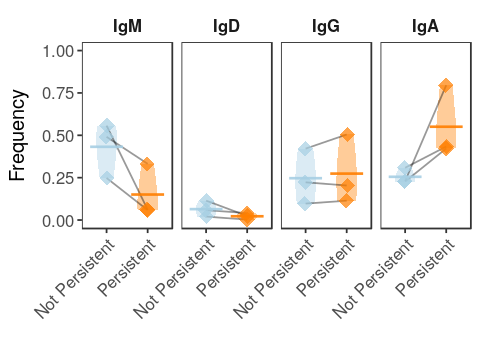

In [334]:
options(repr.plot.width=4, repr.plot.height=3)

p <- ggplot(filter(isotype_tab, RELAPSE == "Post-RTX"), aes(x=PERSISTENT, y=FREQ)) +
    baseTheme() + 
        theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=10), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    scale_y_continuous(limits=c(0,1.0))+
    ylab(expression("Frequency")) +
    scale_fill_manual(values=PERSIST_COLORS, name="Isotype") +
    scale_color_manual(values=PERSIST_COLORS, name="Isotype") +
    geom_violin(aes(fill=PERSISTENT), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = PATIENT), alpha = 0.4) +
    geom_errorbarh(data=isotype_sum, 
                   aes(y=MEAN, color=PERSISTENT, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=PERSISTENT), position=position_jitter(w = 0.02, h = 0), size=4, pch=18, alpha=0.7)+
    facet_grid(. ~ CREGION)
plot(p)

In [335]:
isotype_sum

CREGION PERSISTENT     MEAN      
1 IgM     Not Persistent 0.43207749
2 IgM     Persistent     0.15040862
3 IgD     Not Persistent 0.06443246
4 IgD     Persistent     0.02235261
5 IgG     Not Persistent 0.24696212
6 IgG     Persistent     0.27418924
7 IgA     Not Persistent 0.25516892
8 IgA     Persistent     0.55039526

In [336]:
filter(isotype_tab, RELAPSE == "Post-RTX") %>%
    group_by(CREGION) %>%
    do(computeTest(.,value="FREQ", comparison = "PERSISTENT"))

CREGION P_PAIR    P_UNPAIR   P_WILCOX DIFF        COMPARE                  
1 IgM     0.1201026 0.09715325 0.2       0.28166888 Not Persistent-Persistent
2 IgD     0.2258650 0.22807918 0.4       0.04207986 Not Persistent-Persistent
3 IgG     0.4594648 0.86589857 1.0      -0.02722712 Not Persistent-Persistent
4 IgA     0.1631203 0.07809083 0.1      -0.29522634 Not Persistent-Persistent

In [337]:
aov(FREQ ~ PERSISTENT * CREGION, data = filter(isotype_tab, RELAPSE == "Post-RTX")) %>% summary()

                   Df Sum Sq Mean Sq F value  Pr(>F)   
PERSISTENT          1 0.0000 0.00000   0.000 0.99572   
CREGION             3 0.4070 0.13568   6.402 0.00469 **
PERSISTENT:CREGION  3 0.2535 0.08450   3.987 0.02685 * 
Residuals          16 0.3391 0.02119                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [338]:
plotFigure(p, file.path(PLOT_DIR, "persistent_isotype_unique.pdf"), 4, 3)

png 
  2

In [339]:
plotSvg(p, file.path(PLOT_DIR, "persistent_isotype_unique.svg"), 4, 3)

png 
  2

### SHM vs Persistence

In [344]:
# Compute the average SHM
mu_tab <- DF %>%
    rowwise()  %>%
    mutate(PERSISTENT = if(PERSISTENT_CLONE){"Persistent"}else{"Not Persistent"}) %>%
    ungroup() %>%
    mutate(CREGION = factor(CREGION, levels=ISOTYPE_ORDER)) %>%
    group_by(PERSISTENT, PATIENT, CREGION, RELAPSE) %>%
    summarize(MEAN = mean(MU_FREQ)) %>%
    ungroup() %>%
    filter(CREGION %in% ISOTYPE_ORDER) %>%
    mutate(CREGION = factor(CREGION, levels=ISOTYPE_ORDER))

Warning message:
“Factor `CREGION` contains implicit NA, consider using `forcats::fct_explicit_na`”

In [345]:
mu_sum <- filter(mu_tab, RELAPSE == "Post-RTX") %>%
    group_by(CREGION, PERSISTENT) %>%
    summarize(MEAN = mean(MEAN))

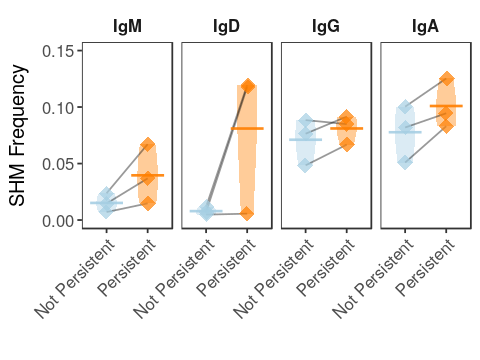

In [346]:
options(repr.plot.width=4, repr.plot.height=3)

p <- ggplot(filter(mu_tab, RELAPSE == "Post-RTX"), aes(x=PERSISTENT, y=MEAN)) +
    baseTheme() + 
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=10), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    scale_y_continuous(limits=c(0,0.15))+
    ylab(expression("SHM Frequency")) +
    scale_fill_manual(values=PERSIST_COLORS, name="Isotype") +
    scale_color_manual(values=PERSIST_COLORS, name="Isotype") +
    geom_violin(aes(fill=PERSISTENT), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = PATIENT), alpha=0.4) +
    geom_errorbarh(data=mu_sum, 
                   aes(y=MEAN, color=PERSISTENT, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=PERSISTENT), position=position_jitter(w = 0.02, h = 0), size=4, pch=18, alpha=0.7) +
    facet_grid(. ~ CREGION)
plot(p)

In [347]:
mu_tab %>%
    filter(RELAPSE == "Post-RTX") %>%
    group_by(CREGION) %>%
    do(computeTest(.,value = "MEAN", comparison = "PERSISTENT"))

CREGION P_PAIR     P_UNPAIR  P_WILCOX DIFF        COMPARE                  
1 IgM     0.14239449 0.1994999 0.2      -0.02445359 Not Persistent-Persistent
2 IgD     0.18048594 0.1247218 0.4      -0.07309924 Not Persistent-Persistent
3 IgG     0.28121578 0.5148270 0.7      -0.00998667 Not Persistent-Persistent
4 IgA     0.05528712 0.2918846 0.4      -0.02323994 Not Persistent-Persistent

In [348]:
plotFigure(p, file.path(PLOT_DIR, "persistent_shm.pdf"), 4, 3)

png 
  2

In [349]:
plotSvg(p, file.path(PLOT_DIR, "persistent_shm.svg"), 4, 3)

png 
  2

### Significance: ANOVA

In [350]:
aov(MEAN ~ PERSISTENT * CREGION, data = filter(mu_tab, RELAPSE == "Post-RTX")) %>% summary()

                   Df   Sum Sq  Mean Sq F value  Pr(>F)   
PERSISTENT          1 0.006414 0.006414   7.636 0.01385 * 
CREGION             3 0.014548 0.004849   5.773 0.00714 **
PERSISTENT:CREGION  3 0.003458 0.001153   1.372 0.28702   
Residuals          16 0.013439 0.000840                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

# Investigate Clone 10408 Further (see R_PlotTrees.ipynb for analysis)

In [360]:
# What is the size of the clone in the bulk repertoire?
DF %>%
   filter(PATIENT == '3', RELAPSE == "Post-RTX") %>%
   group_by(CLONE) %>%
   summarize(COUNT = n()) %>%
   ungroup() %>%
   mutate(FREQ = COUNT/sum(COUNT)) %>%
   arrange(-FREQ) %>%
   mutate(ID = row_number(), PERCENTILE = 1 - (ID/n())) %>%
   filter(CLONE == 10408)

CLONE COUNT FREQ        ID PERCENTILE
1 10408 245   0.004724075 9  0.9991322

In [361]:
# Extract the MRCA sequence
mrca_seq <- getMRCA(GRAPHS[['3,10408']])['sequence']  %>% as.character()

In [362]:
# Output for 
DF_TETRAMER_CLONES_COLLAPSE %>%
    filter(PATIENT_CLONE == '3,10408') %>%
    rowwise() %>%
    select(
            SEQUENCE_ID, 
        SOURCE, RELAPSE, CELL, SANGER_ID, STRENGTH, CREGION, C_CALL, CONSCOUNT, DUPCOUNT, MFI, POSITIVE,
        MU_FREQ_SEQ_R, MU_FREQ, SEQUENCE_IMGT, GERMLINE_IMGT_D_MASK, SEQUENCE_INPUT, CLONE, V_CALL, J_CALL, JUNCTION) %>%
    mutate(SEQUENCE_MRCA = mrca_seq) %>%
    mutate(SEQUENCE_ID = strsplit(SEQUENCE_ID, split=",")[[1]][1]) %>%
    writeChangeoDb(file.path(PLOT_DIR, "CLONE10408.tab"))

# Plot Specific Trees (See R_PlotTrees for final version)

In [77]:
# Count pre-relapse antigen specific clones
traceable_clones <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(PATIENT_CLONE, PATIENT) %>%
    summarize(RELAPSE = paste(unique(RELAPSE), collapse=','), SET = paste(unique(SET), collapse=','), COUNT = n()) %>%
    filter(grepl("JCI", SET) | grepl("TK_PUB", SET), grepl("Pre-RTX", RELAPSE)) %>%
    filter(COUNT > 1) %>% select(PATIENT_CLONE) %>% unlist()

In [78]:
# Count relapse+pre-relapse antigen specific clones
binder_clones <- DF_TETRAMER_CLONES_COLLAPSE %>%
    group_by(PATIENT_CLONE, PATIENT) %>%
    summarize(STRENGTH = paste(unique(STRENGTH), collapse=','), SOURCE = paste(unique(SOURCE), collapse=','), COUNT = n()) %>%
    filter(grepl("HIGH", STRENGTH) | grepl("MEDIUM", STRENGTH) | grepl("POSITIVE", STRENGTH), grepl("Bulk", SOURCE)) %>%
    filter(COUNT > 1) %>% select(PATIENT_CLONE) %>% unlist()

In [79]:
unique(c(traceable_clones, binder_clones))

[1] "1,153300" "1,79998"  "3,10408"  "3,1933"   "3,4322"   "3,5233"  
 [7] "3,6300"   "1,168273" "3,10114"  "3,12344"

In [80]:
EVENT_COLORS <- c(
"Pre-RTX"='#4477AA',
"Post-RTX" = '#CC6677',
# "Infusion" = "#006633",
"Pre-RTX & PRR" = "#AAAAAA"
)
COLORS <- EVENT_COLORS

In [86]:
OUT_PATH <- PLOT_DIR

In [87]:
for(patient_clone in unique(c(traceable_clones, binder_clones))){
    
    sanger_id <- DF_TETRAMER_CLONES_COLLAPSE %>% filter(PATIENT_CLONE ==  patient_clone) %>%
            select(SANGER_ID) %>% unlist() %>% na.omit()
    
    plot_file <- paste0("TreeGraphs", "_", patient_clone, "_", paste(sanger_id, collapse = ",") "_", format(Sys.time(), "%Y-%m-%d"), ".svg")
    
    #options(repr.plot.width=6, repr.plot.height=6)

    svg(file.path(OUT_PATH, "antigen_overlap_unique", plot_file), 5,5, bg="transparent")

    g <- GRAPHS[[patient_clone]]

    #Vertex color
    V(g)$color <- sapply(V(g)$RELAPSE, function(relapse)
        if(grepl(",", relapse)){
            return("#AAAAAA")
        } else {
            return(COLORS[relapse])
        }
        
    )                     
    #V(g)$color <- sapply(V(g)$TIME, function(time) return(COLORS[time]))
    V(g)$color[V(g)$name == "Germline"] <- "#000000"
    V(g)$color[grepl("Inferred", V(g)$name)] <- "#FFFFFF"

    # Vertex shape
    V(g)$shape <- rep("circle", length(V(g)$name))

    V(g)$shape[is.na(V(g)$shape)] <- "circle"
    V(g)$shape[grepl("Query", V(g)$SOURCE)] <- "rectangle"
    V(g)$shape["Query" == V(g)$SOURCE] <- "csquare"

    # Vertex text
    uid <- !grepl("Inferred|Germline", V(g)$name)
    V(g)$label[uid] <- V(g)$CREGION[uid]
    V(g)$label[!uid] <- "" 

    # Vertex size
    V(g)$label.cex <- 0.3
    V(g)$size[!uid] <- 10
    V(g)$size[uid] <- 20

    # Edge labels
    E(g)$label <- E(g)$weight
    E(g)$label.cex <- 0.4               


    main <- paste0(g$v_gene, "/", g$j_gene, "/" , g$junc_len, " ", patient_clone)

    # Plot graph as a tree
    ly <- layout.reingold.tilford(g, root="Germline", circular=F, flip.y=T)
    plot(g, layout=ly,
         rescale=T,
         edge.arrow.mode=0, 
         vertex.label.family="Helvetica",
         edge.label.color="black", 
         vertex.frame.color="black",
         vertex.label.color="black",
        vertex.label.family="Helvetica")

    dev.off()

}

In [183]:
selection <- unique(c(traceable_clones, binder_clones))
selection <- c('3,10408')

In [196]:
for(patient_clone in selection){
    
    sanger_id <- DF_TETRAMER_CLONES_COLLAPSE %>% filter(PATIENT_CLONE ==  patient_clone) %>%
            select(SANGER_ID) %>% unlist() %>% na.omit()
    
    plot_file <- paste0("TreeGraphsNamed", "_", patient_clone, "_", paste(sanger_id, collapse = ","), "_", format(Sys.time(), "%Y-%m-%d"),
                        ".pdf")
    
    #options(repr.plot.width=6, repr.plot.height=6)

    pdf(file.path(OUT_PATH, "antigen_overlap_unique", plot_file), 20,30, bg="transparent")

    g <- GRAPHS[[patient_clone]]

    #Vertex color
    V(g)$color <- sapply(V(g)$RELAPSE, function(relapse)
        if(grepl(",", relapse)){
            return("#AAAAAA")
        } else {
            return(COLORS[relapse])
        }
        
    )                     
    #V(g)$color <- sapply(V(g)$TIME, function(time) return(COLORS[time]))
    V(g)$color[V(g)$name == "Germline"] <- "#000000"
    V(g)$color[grepl("Inferred", V(g)$name)] <- "#FFFFFF"

    # Vertex shape
    V(g)$shape <- rep("circle", length(V(g)$name))

    V(g)$shape[is.na(V(g)$shape)] <- "circle"
    V(g)$shape[grepl("10X", V(g)$SOURCE)] <- "rectangle"
    V(g)$shape["Sanger" == V(g)$SOURCE] <- "csquare"

    # Vertex text
    uid <- !grepl("Inferred|Germline", V(g)$name)
    V(g)$label[uid] <- V(g)$X1[uid]
    V(g)$label[!uid] <- "" 

    # Vertex size
    V(g)$label.cex <- 0.12
    V(g)$size[!uid] <- 1
    V(g)$size[uid] <- 2

    # Edge labels
    E(g)$label <- E(g)$weight
    E(g)$label.cex <- 0.1
                         


    main <- paste0(g$v_gene, "/", g$j_gene, "/" , g$junc_len, " ", patient_clone)

    # Plot graph as a tree
    ly <- layout.reingold.tilford(g, root="Germline", circular=F, flip.y=T)
    plot(g, layout=ly,
         rescale=T,
         edge.arrow.mode=0, 
         vertex.label.family="Helvetica",
         edge.label.color="black", 
         vertex.frame.color="black",
         vertex.label.color="black",
        vertex.label.family="Helvetica")

    dev.off()

}

In [197]:
for(patient_clone in selection){
    
    sanger_id <- DF_TETRAMER_CLONES_COLLAPSE %>% filter(PATIENT_CLONE ==  patient_clone) %>%
            select(SANGER_ID) %>% unlist() %>% na.omit()
    
    plot_file <- paste0("TreeGraphsSanger", "_", patient_clone, "_", paste(sanger_id, collapse = ","), "_", format(Sys.time(), "%Y-%m-%d"),
                        ".pdf")
    
    #options(repr.plot.width=6, repr.plot.height=6)

    pdf(file.path(OUT_PATH, "antigen_overlap_unique", plot_file), 20,30, bg="transparent")

    g <- GRAPHS[[patient_clone]]

    #Vertex color
    V(g)$color <- sapply(V(g)$RELAPSE, function(relapse)
        if(grepl(",", relapse)){
            return("#AAAAAA")
        } else {
            return(COLORS[relapse])
        }
        
    )                     
    #V(g)$color <- sapply(V(g)$TIME, function(time) return(COLORS[time]))
    V(g)$color[V(g)$name == "Germline"] <- "#000000"
    V(g)$color[grepl("Inferred", V(g)$name)] <- "#FFFFFF"

    # Vertex shape
    V(g)$shape <- rep("circle", length(V(g)$name))

    V(g)$shape[is.na(V(g)$shape)] <- "circle"
    V(g)$shape[grepl("10X", V(g)$SOURCE)] <- "rectangle"
    V(g)$shape["Sanger" == V(g)$SOURCE] <- "csquare"

    # Vertex text
    uid <- !grepl("Inferred|Germline", V(g)$name)
    V(g)$label[uid] <- V(g)$SANGER_ID[uid]
    V(g)$label[!uid] <- "" 

    # Vertex size
    V(g)$label.cex <- 0.12
    V(g)$size[!uid] <- 1
    V(g)$size[uid] <- 2

    # Edge labels
    E(g)$label <- E(g)$weight
    E(g)$label.cex <- 0.1
                         


    main <- paste0(g$v_gene, "/", g$j_gene, "/" , g$junc_len, " ", patient_clone)

    # Plot graph as a tree
    ly <- layout.reingold.tilford(g, root="Germline", circular=F, flip.y=T)
    plot(g, layout=ly,
         rescale=T,
         edge.arrow.mode=0, 
         vertex.label.family="Helvetica",
         edge.label.color="black", 
         vertex.frame.color="black",
         vertex.label.color="black",
        vertex.label.family="Helvetica")

    dev.off()

}

In [89]:
OUT_PATH <- PLOT_DIR
plot_file <- paste0("Legend", "_", format(Sys.time(), "%Y-%m-%d"), ".svg")

svg(file.path(OUT_PATH, plot_file), 5.5,5.5 , bg = "transparent")

plot.new()
# Add legend
legend_colors <- COLORS
legend("topleft", 
       c("Germline", "Inferred", names(legend_colors)),
       fill=c("#000000", "#FFFFFF", legend_colors), 
       bty="n",
       cex=2)

dev.off()

png 
  2

# Export Change-O for improved tree plotting (R_PlotTrees)

In [354]:
DF_TETRAMER_CLONES_COLLAPSE %>% 
    filter(PATIENT_CLONE %in% unique(c(traceable_clones))) %>%
    mutate(CREGION_SOURCE = if(SOURCE != "Sanger"){CREGION}else{"Query"}) %>%
    writeChangeoDb(tree_toplot_file)

Warning message in if (SOURCE != "Sanger") {:
“the condition has length > 1 and only the first element will be used”

# Clonal Overlap

In [ ]:
DF_GERM_MERGE_OVERLAP <- DF_GERM_MERGE %>%
    group_by(PATIENT) %>%
    runDefineClones(clone_threshold = common_threshold) %>%
    runCreateGermlines(ref_dir = ref_dir) %>%
    observedMutations(frequency=TRUE) %>%
    mutate(MU_FREQ = MU_FREQ_SEQ_R + MU_FREQ_SEQ_S) %>%
	filter(FUNCTIONAL) 

DF_GERM_MERGE_OVERLAP %>% writeChangeoDb(db_unique_overlap_file)	

Warning message in rbind(names(probs), probs_f):
“number of columns of result is not a multiple of vector length (arg 1)”Warning message:
“714 parsing failures.
row # A tibble: 5 x 5 col     row col         expected            actual file                              expected   <int> <chr>       <chr>               <chr>  <chr>                             actual 1  2248 PATIENT_CL… no trailing charac… e3     '/tmp/RtmpUmK0Lp/445be99d5df_clo… file 2  3540 PATIENT_CL… no trailing charac… e3     '/tmp/RtmpUmK0Lp/445be99d5df_clo… row 3  3541 PATIENT_CL… no trailing charac… e3     '/tmp/RtmpUmK0Lp/445be99d5df_clo… col 4  3542 PATIENT_CL… no trailing charac… e3     '/tmp/RtmpUmK0Lp/445be99d5df_clo… expected 5  3543 PATIENT_CL… no trailing charac… e3     '/tmp/RtmpUmK0Lp/445be99d5df_clo…
... ................. ... ................................................................................ ........ ................................................................................ ...... ....

In [91]:
dim(DF_GERM_MERGE_OVERLAP)

[1] 839731     82

In [148]:
DF_GERM_MERGE_OVERLAP <- read.csv(db_unique_overlap_file, sep = '\t')

In [149]:
DF_OVERLAP <- DF_GERM_MERGE_OVERLAP %>%
    filter(SOURCE == "Bulk")

### Venn-Diagrams

In [150]:
venn_diagrams <- DF_OVERLAP %>%
    group_by(PATIENT, CLONE) %>%
    summarize(REL = any(RELAPSE == 'Post-RTX'), PREREL = any(RELAPSE == 'Pre-RTX'), OVERLAP = PREREL & REL) %>%
    group_by(PATIENT) %>%
    summarize(OVERLAP = sum(OVERLAP), RELAPSE_ONLY = sum(REL) - OVERLAP, PRERELAPSE_ONLY = sum(PREREL) - OVERLAP, TOTAL = PRERELAPSE_ONLY + RELAPSE_ONLY + OVERLAP) %>%
    mutate(RELAPSE_OVERLAP_FRAC = OVERLAP/(OVERLAP+RELAPSE_ONLY))

In [151]:
venn_diagrams

PATIENT OVERLAP RELAPSE_ONLY PRERELAPSE_ONLY TOTAL  RELAPSE_OVERLAP_FRAC
1 1       2462    34456        150034          186952 0.06668834          
2 2        902    16127         17541           34570 0.05296847          
3 3        345     9999          4204           14548 0.03335267

In [153]:
write.csv(venn_diagrams, file.path(PLOT_DIR, "persist_table_unique.csv"))

In [152]:
options(repr.plot.width=3, repr.plot.height=3)
for(patient in unique(PATIENT_DICT)){
    v <- venn.diagram(filename = NULL, category = c("", ""), fontfamily = "sans",
    x = list(filter(DF_GERM_MERGE, RELAPSE == "Pre-RTX", PATIENT == patient)$CLONE, 
             filter(DF_GERM_MERGE, RELAPSE == "Post-RTX", PATIENT == patient)$CLONE))
    
    pdf(file.path(PLOT_DIR, paste0(patient, "_venndiagram_unique.pdf")), 3,3)
    grid.draw(v)
    dev.off()
}

Warning message in grid.Call(C_getEngineDLon):
“Cannot open temporary file '/tmp/RtmpMHf326/pdfdbebb7fe46189' for compression (reason: No such file or directory); compression has been turned off for this device”Warning message in grid.Call(C_getEngineDLon):
“Cannot open temporary file '/tmp/RtmpMHf326/pdfdbebb3d278e1f' for compression (reason: No such file or directory); compression has been turned off for this device”Warning message in grid.Call(C_getEngineDLon):
“Cannot open temporary file '/tmp/RtmpMHf326/pdfdbebb688c6a42' for compression (reason: No such file or directory); compression has been turned off for this device”

### Across all others, will have problems with improper balancing (not used for publication, Steve request)

In [46]:
overlap_list <- list()
for(patient in unique(PATIENT_DICT)){
    overlap_list[[patient]] <- DF %>%
        mutate(SAME_PATIENT = if(PATIENT == patient){"INTRA"}else{"INTER"}) %>%
        mutate(SAME_PATIENT_RELAPSE = paste(SAME_PATIENT, RELAPSE, sep = "_")) %>%
        runQuantifyOverlap(group = "SAME_PATIENT_RELAPSE", clone = "CLONE", action = "sorenson") %>%
        filter(index == "INTRA_Post-RTX", grepl("Pre-RTX", SAME_PATIENT_RELAPSE))   
}

In [47]:
overlap_df <- bind_rows(overlap_list, .id = "PATIENT")

In [48]:
overlap_df 

PATIENT X  index     SAME_PATIENT_RELAPSE OVERLAP    
1 3        6 INTRA_PRR INTER_Pre-RTX        0.001907148
2 3       14 INTRA_PRR INTRA_Pre-RTX        0.026355685
3 2        6 INTRA_PRR INTER_Pre-RTX        0.003359868
4 2       14 INTRA_PRR INTRA_Pre-RTX        0.039175974
5 1        6 INTRA_PRR INTER_Pre-RTX        0.004501062
6 1       14 INTRA_PRR INTRA_Pre-RTX        0.015642579

In [41]:
count_overlap_list <- list()
for(patient in unique(PATIENT_DICT)){
    count_overlap_list[[patient]] <- DF %>%
        mutate(SAME_PATIENT = if(PATIENT == patient){"INTRA"}else{"INTER"}) %>%
        mutate(SAME_PATIENT_RELAPSE = paste(SAME_PATIENT, RELAPSE, sep = "_")) %>%
        runQuantifyOverlap(group = "SAME_PATIENT_RELAPSE", clone = "CLONE", action = "count_bool") %>%
        filter(index == "INTRA_Post-RTX", grepl("Pre-RTX", SAME_PATIENT_RELAPSE))   
}

In [42]:
count_overlap_df <- bind_rows(count_overlap_list, .id = "PATIENT")

In [43]:
count_overlap_df

PATIENT X  index     SAME_PATIENT_RELAPSE OVERLAP
1 3        6 INTRA_PRR INTER_Pre-RTX         172   
2 3       14 INTRA_PRR INTRA_Pre-RTX         226   
3 2        6 INTRA_PRR INTER_Pre-RTX         260   
4 2       14 INTRA_PRR INTRA_Pre-RTX         677   
5 1        6 INTRA_PRR INTER_Pre-RTX         159   
6 1       14 INTRA_PRR INTRA_Pre-RTX        1154

### Counts (for text)

In [118]:
total_count_overlap_df <- DF_OVERLAP %>%
    mutate(PATIENT_RELAPSE = paste(PATIENT, RELAPSE, sep = "_")) %>%
    runQuantifyOverlap(group = "PATIENT_RELAPSE", clone = "CLONE", action = "count_bool")

In [33]:
total_count_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(index), '_')[[1]][1]) %>%
    filter(grepl("Pre-RTX", index), grepl(PATIENT, PATIENT_RELAPSE), grepl("Post-RTX", PATIENT_RELAPSE)) 

X  index     PATIENT_RELAPSE OVERLAP PATIENT
1  1 1_Pre-RTX 1_Post-RTX      2462    1      
2 15 2_Pre-RTX 2_Post-RTX       902    2      
3 29 3_Pre-RTX 3_Post-RTX       345    3

In [66]:
total_mean_count_overlap <- total_count_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(index), '_')[[1]][1]) %>%
    filter(grepl("Pre-RTX", index), grepl(PATIENT, PATIENT_RELAPSE), grepl("Post-RTX", PATIENT_RELAPSE)) %>%
    group_by(index) %>%
    summarize(MEAN = mean(OVERLAP))

total_mean_count_overlap

Warning message:
“Grouping rowwise data frame strips rowwise nature”

index     MEAN
1 1_Pre-RTX 2462
2 2_Pre-RTX  902
3 3_Pre-RTX  345

In [67]:
total_mean_count_overlap$MEAN %>% mean()

[1] 1236.333

In [68]:
foreground <- DF_OVERLAP %>%
    group_by(PATIENT, RELAPSE) %>%
    summarize(COUNT = length(unique(CLONE))) %>%
    filter(RELAPSE == 'Pre-RTX') %>%
    mutate(index = paste(PATIENT, RELAPSE, sep='_')) %>%
    left_join(total_mean_count_overlap, .id="index") %>%
    mutate(FREQ = MEAN/COUNT)
foreground 

Joining, by = "index"
Warning message:
“Column `index` joining character vector and factor, coercing into character vector”

PATIENT RELAPSE COUNT  index     MEAN FREQ      
1 1       Pre-RTX 152496 1_Pre-RTX 2462 0.01614469
2 2       Pre-RTX  18443 2_Pre-RTX  902 0.04890744
3 3       Pre-RTX   4549 3_Pre-RTX  345 0.07584084

In [51]:
total_count_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(index), '_')[[1]][1]) %>%
    filter(grepl("Pre-RTX", index), index != PATIENT_RELAPSE) %>%
    filter(!(grepl(PATIENT, PATIENT_RELAPSE)) & !(grepl("Pre-RTX", PATIENT_RELAPSE))) 

X  index     PATIENT_RELAPSE OVERLAP PATIENT
1  3 2_Pre-RTX 1_Post-RTX      389     2      
2  5 3_Pre-RTX 1_Post-RTX       60     3      
3 13 1_Pre-RTX 2_Post-RTX      624     1      
4 17 3_Pre-RTX 2_Post-RTX       22     3      
5 25 1_Pre-RTX 3_Post-RTX      491     1      
6 27 2_Pre-RTX 3_Post-RTX      132     2

In [70]:
total_mean_count_overlap <- total_count_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(index), '_')[[1]][1]) %>%
    filter(grepl("Pre-RTX", index), index != PATIENT_RELAPSE) %>%
    filter(!(grepl(PATIENT, PATIENT_RELAPSE)) & !(grepl("Pre-RTX", PATIENT_RELAPSE))) %>%
    group_by(index) %>%
    summarize(MEAN = mean(OVERLAP))
total_mean_count_overlap

Warning message:
“Grouping rowwise data frame strips rowwise nature”

index     MEAN 
1 1_Pre-RTX 557.5
2 2_Pre-RTX 260.5
3 3_Pre-RTX  41.0

In [71]:
background <- DF_OVERLAP %>%
    group_by(PATIENT, RELAPSE) %>%
    summarize(COUNT = length(unique(CLONE))) %>%
    filter(RELAPSE == 'Pre-RTX') %>%
    mutate(index = paste(PATIENT, RELAPSE, sep='_')) %>%
    left_join(total_mean_count_overlap, .id="index") %>%
    mutate(FREQ = MEAN/COUNT) 
background

Joining, by = "index"
Warning message:
“Column `index` joining character vector and factor, coercing into character vector”

PATIENT RELAPSE COUNT  index     MEAN  FREQ       
1 1       Pre-RTX 152496 1_Pre-RTX 557.5 0.003655834
2 2       Pre-RTX  18443 2_Pre-RTX 260.5 0.014124600
3 3       Pre-RTX   4549 3_Pre-RTX  41.0 0.009012970

In [72]:
DF_OVERLAP %>%
    group_by(PATIENT, RELAPSE) %>%
    summarize(COUNT = length(unique(CLONE))) %>%
    filter(RELAPSE == 'Pre-RTX') %>%
    mutate(index = paste(PATIENT, RELAPSE, sep='_')) %>%
    left_join(total_mean_count_overlap, .id="index") %>%
    mutate(FREQ = MEAN/COUNT) %>% ungroup() %>% summarize(FREQ = mean(FREQ))

Joining, by = "index"
Warning message:
“Column `index` joining character vector and factor, coercing into character vector”

FREQ       
1 0.008931135

### Plotting

In [75]:
# get the mean for pairwise comparisons
toplot_df <- bind_rows(
    mutate(foreground, CROSS_SAMPLE = "Intra-Patient"),
    mutate(background, CROSS_SAMPLE = "Inter-Patient")
) %>% select(PATIENT, CROSS_SAMPLE, FREQ) %>% rename(OVERLAP = FREQ)

In [76]:
OVERLAP_COLORS = c(
"Intra-Patient" = "#636363",
'Inter-Patient' = "#bdbdbd"
)

In [77]:
toplot_df

PATIENT CROSS_SAMPLE  OVERLAP    
1 1       Intra-Patient 0.016144686
2 2       Intra-Patient 0.048907445
3 3       Intra-Patient 0.075840844
4 1       Inter-Patient 0.003655834
5 2       Inter-Patient 0.014124600
6 3       Inter-Patient 0.009012970

In [78]:
overlap_sum <- toplot_df %>%
    group_by(CROSS_SAMPLE) %>%
    summarize(MEAN=mean(OVERLAP, na.rm=T), SD=sd(OVERLAP, na.rm=T))   

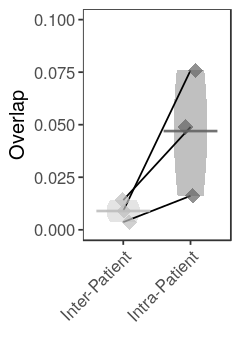

In [80]:
options(repr.plot.width=2, repr.plot.height=3)

p <- ggplot(toplot_df, aes(x=CROSS_SAMPLE, y=OVERLAP)) + 
    baseTheme() + 
    scale_y_continuous(limits= c(0, 0.1)) +
    scale_fill_manual(values=OVERLAP_COLORS, name="Comparison") +
    scale_color_manual(values=OVERLAP_COLORS, name="Comparison") +
    geom_violin(aes(fill=CROSS_SAMPLE), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
        #geom_line(aes(group = PAIR)) +
    geom_line(aes(group = PATIENT)) + 
    geom_errorbarh(data=overlap_sum, 
                       aes(y=MEAN, color=CROSS_SAMPLE, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                       height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=CROSS_SAMPLE), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    xlab("") +
    ylab("Overlap") +
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=10), legend.text=element_text(size=10), legend.title=element_text(size=12))
    #theme(axis.text.x=element_text(size=8, angle =45, hjust= 1, vjust=1), legend.position="none") +
plot(p)

In [91]:
### ratio t-test
t.test(log(filter(toplot_df, CROSS_SAMPLE == "Inter-Patient")$OVERLAP), 
       log(filter(toplot_df, CROSS_SAMPLE == "Intra-Patient")$OVERLAP), paired=TRUE, alternative="less")


	Paired t-test

data:  log(filter(toplot_df, CROSS_SAMPLE == "Inter-Patient")$OVERLAP) and log(filter(toplot_df, CROSS_SAMPLE == "Intra-Patient")$OVERLAP)
t = -3.4406, df = 2, p-value = 0.03754
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf -0.2893455
sample estimates:
mean of the differences 
              -1.912264 


### Bray-Curtis

In [122]:
total_overlap_df <- DF_OVERLAP %>%
    filter(SOURCE == "Bulk") %>%
    mutate(PATIENT_RELAPSE = paste(PATIENT, RELAPSE, sep = "_")) %>%
    runQuantifyOverlap(group = "PATIENT_RELAPSE", clone = "CLONE", action = "sorenson")

In [111]:
total_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(index), '_')[[1]][1]) %>%
    filter(grepl("Post-RTX", index), index != PATIENT_RELAPSE) %>%
    mutate(CROSS_SAMPLE = if(!(grepl(PATIENT, index)) | !(grepl(PATIENT, PATIENT_RELAPSE))){"Inter-Patient"}else{"Intra-Patient"}) 

X  index      PATIENT_RELAPSE OVERLAP     PATIENT CROSS_SAMPLE 
1   2 2_Post-RTX 1_Post-RTX      0.008830381 2       Inter-Patient
2   4 3_Post-RTX 1_Post-RTX      0.006663416 3       Inter-Patient
3   6 1_Post-RTX 1_Pre-RTX       0.016144686 1       Intra-Patient
4   8 2_Post-RTX 1_Pre-RTX       0.004091911 2       Inter-Patient
5  10 3_Post-RTX 1_Pre-RTX       0.003219757 3       Inter-Patient
6  12 1_Post-RTX 2_Post-RTX      0.008830381 1       Inter-Patient
7  16 3_Post-RTX 2_Post-RTX      0.004991485 3       Inter-Patient
8  18 1_Post-RTX 2_Pre-RTX       0.010536865 1       Inter-Patient
9  20 2_Post-RTX 2_Pre-RTX       0.048907445 2       Intra-Patient
10 22 3_Post-RTX 2_Pre-RTX       0.007157187 3       Inter-Patient
11 24 1_Post-RTX 3_Post-RTX      0.006663416 1       Inter-Patient
12 26 2_Post-RTX 3_Post-RTX      0.004991485 2       Inter-Patient
13 30 1_Post-RTX 3_Pre-RTX       0.001625223 1       Inter-Patient
14 32 2_Post-RTX 3_Pre-RTX       0.001291914 2       Inter-Patient
15 34 3_Post-RTX 3_Pre-RTX       0.033352668 3       Intra-Patient

In [124]:
# get the mean for pairwise comparisons
toplot_df <- total_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(index), '_')[[1]][1]) %>%
    filter(grepl("Post-RTX", index), index != PATIENT_RELAPSE) %>%
    mutate(CROSS_SAMPLE = if(!(grepl(PATIENT, index)) | !(grepl(PATIENT, PATIENT_RELAPSE))){"Inter-Patient"}else{"Intra-Patient"}) %>%
    filter(!grepl("Post-RTX", PATIENT_RELAPSE)) %>%
    group_by(PATIENT, CROSS_SAMPLE) %>%
    summarize(OVERLAP = mean(OVERLAP))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [390]:
OVERLAP_COLORS = c(
"Intra-Patient" = "#636363",
'Inter-Patient' = "#bdbdbd"
)

In [125]:
toplot_df

PATIENT CROSS_SAMPLE  OVERLAP    
1 1       Inter-Patient 0.006081044
2 1       Intra-Patient 0.016144686
3 2       Inter-Patient 0.002691912
4 2       Intra-Patient 0.048907445
5 3       Inter-Patient 0.005188472
6 3       Intra-Patient 0.033352668

In [129]:
overlap_sum <- toplot_df %>%
    group_by(CROSS_SAMPLE) %>%
    summarize(MEAN=mean(OVERLAP, na.rm=T), SD=sd(OVERLAP, na.rm=T))   

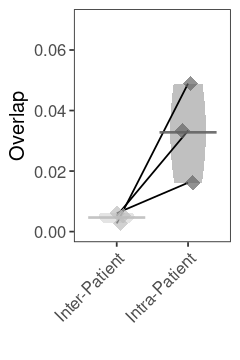

In [130]:
options(repr.plot.width=2, repr.plot.height=3)

p <- ggplot(toplot_df, aes(x=CROSS_SAMPLE, y=OVERLAP)) + 
    baseTheme() + 
    scale_y_continuous(limits= c(0, 0.07)) +
    scale_fill_manual(values=OVERLAP_COLORS, name="Comparison") +
    scale_color_manual(values=OVERLAP_COLORS, name="Comparison") +
    geom_violin(aes(fill=CROSS_SAMPLE), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
        #geom_line(aes(group = PAIR)) +
    geom_line(aes(group = PATIENT)) + 
    geom_errorbarh(data=overlap_sum, 
                       aes(y=MEAN, color=CROSS_SAMPLE, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                       height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=CROSS_SAMPLE), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    xlab("") +
    ylab("Overlap") +
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=10), legend.text=element_text(size=10), legend.title=element_text(size=12))
    #theme(axis.text.x=element_text(size=8, angle =45, hjust= 1, vjust=1), legend.position="none") +
plot(p)

In [131]:
plotFigure(p, file.path(PLOT_DIR, "braycurtis_total_overlap.pdf"), 2, 3)

png 
  2

In [144]:
plotSvg(p, file.path(PLOT_DIR, "braycurtis_total_overlap.svg"), 2, 3)

png 
  2

In [126]:
computeTest(toplot_df, value = "OVERLAP", comparison = "CROSS_SAMPLE")

P_PAIR    P_UNPAIR   P_WILCOX DIFF        COMPARE                    
1 0.1143609 0.04163949 0.1      -0.02814779 Inter-Patient-Intra-Patient

In [127]:
t.test(log(filter(toplot_df, CROSS_SAMPLE == "Inter-Patient")$OVERLAP), 
       log(filter(toplot_df, CROSS_SAMPLE == "Intra-Patient")$OVERLAP), paired=TRUE, alternative="less")


	Paired t-test

data:  log(filter(toplot_df, CROSS_SAMPLE == "Inter-Patient")$OVERLAP) and log(filter(toplot_df, CROSS_SAMPLE == "Intra-Patient")$OVERLAP)
t = -3.4406, df = 2, p-value = 0.03754
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
       -Inf -0.2893455
sample estimates:
mean of the differences 
              -1.912264 


# Pre-Relapse Overlap (Remission)

In [15]:
DF_OVERLAP_REMISSION <- DF_OVERLAP %>%
    filter(SAMPLE %in% c("MG135", "MG037") | RELAPSE != "Post-RTX") %>%
    rowwise() %>%
    mutate(REMISSION = if(SAMPLE == "MG135"){"Remission"}else{"Pre-Relapse"})

In [16]:
total_overlap_df <- DF_OVERLAP_REMISSION %>%
    mutate(PATIENT_REMISSION = paste(PATIENT, REMISSION, sep = "_")) %>%
    runQuantifyOverlap(group = "PATIENT_REMISSION", clone = "CLONE", action = "sorenson")

In [17]:
# get the mean for pairwise comparisons
toplot_df <- total_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(index), '_')[[1]][1]) %>%
    filter(grepl("Pre-Relapse", index), index != PATIENT_REMISSION) %>%
    mutate(CROSS_SAMPLE = if(!(grepl(PATIENT, index)) | !(grepl(PATIENT, PATIENT_REMISSION))){"Inter-Patient"}else{"Intra-Patient"}) %>%
    filter(!grepl("Pre-Relapse", PATIENT_REMISSION)) %>%
    group_by(PATIENT, CROSS_SAMPLE) %>%
    summarize(OVERLAP = mean(OVERLAP))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [18]:
OVERLAP_COLORS = c(
"Intra-Patient" = "#636363",
'Inter-Patient' = "#bdbdbd"
)

In [19]:
toplot_df

PATIENT CROSS_SAMPLE  OVERLAP    
1 1       Inter-Patient 0.003252544
2 2       Intra-Patient 0.015280826
3 3       Inter-Patient 0.003982768

In [37]:
# overlap_sum <- toplot_df %>%
#     group_by(CROSS_SAMPLE) %>%
#     summarize(MEAN=mean(OVERLAP, na.rm=T), SD=sd(OVERLAP, na.rm=T))   

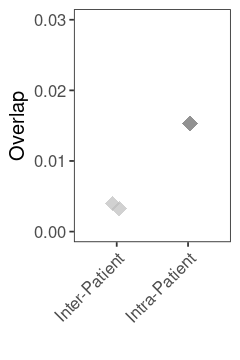

In [22]:
options(repr.plot.width=2, repr.plot.height=3)

p <- ggplot(toplot_df, aes(x=CROSS_SAMPLE, y=OVERLAP)) + 
    baseTheme() + 
    scale_y_continuous(limits= c(0, 0.03)) +
    scale_fill_manual(values=OVERLAP_COLORS, name="Comparison") +
    scale_color_manual(values=OVERLAP_COLORS, name="Comparison") +
    geom_violin(aes(fill=CROSS_SAMPLE), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
        #geom_line(aes(group = PAIR)) +
    #geom_line(aes(group = PATIENT)) + 
    #geom_errorbarh(data=overlap_sum, 
    #                   aes(y=MEAN, color=CROSS_SAMPLE, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
    #                   height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=CROSS_SAMPLE), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    xlab("") +
    ylab("Overlap") +
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=10), legend.text=element_text(size=10), legend.title=element_text(size=12))
    #theme(axis.text.x=element_text(size=8, angle =45, hjust= 1, vjust=1), legend.position="none") +
plot(p)

In [28]:
plotFigure(p, file.path(PLOT_DIR, "braycurtis_total_overlap_remission.pdf"), 2, 3)

png 
  2

In [40]:
plotSvg(p, file.path(PLOT_DIR, "braycurtis_total_overlap_prerelapse.svg"), 2, 3)

png 
  2

In [26]:
log(filter(toplot_df, CROSS_SAMPLE == "Inter-Patient")$OVERLAP)

[1] -5.728318 -5.525778

In [27]:
log(filter(toplot_df, CROSS_SAMPLE == "Intra-Patient")$OVERLAP)

[1] -4.181156

### Frequency of persistent unmutated IgM/D

In [33]:
# Select isotypes of interest (ignoring IgE)
ISOTYPE_ORDER <- c("IgM", "IgD", "IgG", "IgA")

In [70]:
# Compute the average frequency of each isotype
naive_tab <- DF %>%
    filter(CREGION %in% ISOTYPE_ORDER) %>%
    rowwise() %>%
    mutate(NAIVE = if((CREGION == 'IgM' | CREGION == 'IgD') & MU_FREQ == 0){"No Antigen-Experience"}else{"Antigen-Experienced"}) %>%
    group_by(PERSISTENT_CLONE, PATIENT, NAIVE, RELAPSE) %>%
    summarize(COUNT = n()) %>%
    group_by(PERSISTENT_CLONE, PATIENT, RELAPSE) %>%
    mutate(FREQ = COUNT/sum(COUNT))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [95]:
toplot_df <- filter(naive_tab, RELAPSE == "Post-RTX", NAIVE == "No Antigen-Experience") %>%
    rowwise() %>%
    mutate(PERSISTENT = if(PERSISTENT_CLONE){"Persistent"}else{"Not Persistent"})

In [96]:
toplot_sum <- toplot_df %>%
    group_by(PERSISTENT) %>%
    summarize(MEAN = mean(FREQ), SD = sd(FREQ))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [97]:
toplot_sum

PERSISTENT     MEAN       SD        
1 Not Persistent 0.30293939 0.15124391
2 Persistent     0.06074223 0.08726892

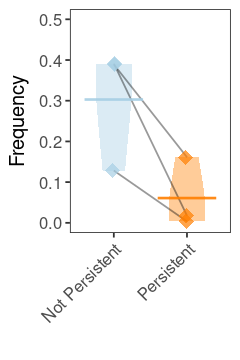

In [98]:
options(repr.plot.width=2, repr.plot.height=3)

p <- ggplot(toplot_df, aes(x=PERSISTENT, y=FREQ)) +
    baseTheme() + 
        theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=10), legend.text=element_text(size=10), legend.title=element_text(size=12)) +
    xlab("") +
    scale_y_continuous(limits=c(0,0.5))+
    ylab(expression("Frequency")) +
    scale_fill_manual(values=PERSIST_COLORS, name="Isotype") +
    scale_color_manual(values=PERSIST_COLORS, name="Isotype") +
    geom_violin(aes(fill=PERSISTENT), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
    geom_line(aes(group = PATIENT), alpha = 0.4) +
    geom_errorbarh(data=toplot_sum, 
                  aes(y=MEAN, color=PERSISTENT, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                  height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=PERSISTENT), position=position_jitter(w = 0.02, h = 0), size=4, pch=18, alpha=0.7)
plot(p)

In [99]:
plotFigure(p, file.path(PLOT_DIR, "naive_overlap_frequency.pdf"), 2, 3)

png 
  2

In [82]:
toplot_df %>% 
computeTest(value = "FREQ", comparison = "PERSISTENT") %>%
mutate(P_PAIR = P_PAIR/2)

P_PAIR     P_UNPAIR   P_WILCOX DIFF      COMPARE                  
1 0.03923497 0.07416241 0.2      0.2421972 Not Persistent-Persistent

### Naive Overlap

In [132]:
total_overlap_df <- DF_OVERLAP %>%
    filter(SOURCE == "Bulk") %>%
    filter((CREGION == 'IgM' | CREGION == 'IgD') & MU_FREQ == 0) %>%
    mutate(PATIENT_RELAPSE = paste(PATIENT, RELAPSE, sep = "_")) %>%
    runQuantifyOverlap(group = "PATIENT_RELAPSE", clone = "CLONE", action = "sorenson")

In [133]:
# get the mean for pairwise comparisons
toplot_df <- total_overlap_df %>%
    rowwise() %>%
    mutate(PATIENT = strsplit(as.character(index), '_')[[1]][1]) %>%
    filter(grepl("Post-RTX", index), index != PATIENT_RELAPSE) %>%
    mutate(CROSS_SAMPLE = if(!(grepl(PATIENT, index)) | !(grepl(PATIENT, PATIENT_RELAPSE))){"Inter-Patient"}else{"Intra-Patient"}) %>%
    filter(!grepl("Post-RTX", PATIENT_RELAPSE)) %>%
    group_by(PATIENT, CROSS_SAMPLE) %>%
    summarize(OVERLAP = mean(OVERLAP))

Warning message:
“Grouping rowwise data frame strips rowwise nature”

In [101]:
toplot_df

PATIENT CROSS_SAMPLE  OVERLAP     
1 1       Inter-Patient 0.0019830441
2 1       Intra-Patient 0.0092400067
3 2       Inter-Patient 0.0012545724
4 2       Intra-Patient 0.0078917700
5 3       Inter-Patient 0.0020202562
6 3       Intra-Patient 0.0004214075

In [134]:
overlap_sum <- toplot_df %>%
    group_by(CROSS_SAMPLE) %>%
    summarize(MEAN=mean(OVERLAP, na.rm=T), SD=sd(OVERLAP, na.rm=T))   

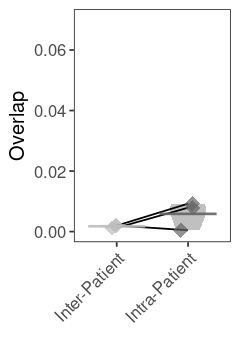

In [135]:
options(repr.plot.width=2, repr.plot.height=3)

p <- ggplot(toplot_df, aes(x=CROSS_SAMPLE, y=OVERLAP)) + 
    baseTheme() + 
    scale_y_continuous(limits= c(0, 0.07)) +
    scale_fill_manual(values=OVERLAP_COLORS, name="Comparison") +
    scale_color_manual(values=OVERLAP_COLORS, name="Comparison") +
    geom_violin(aes(fill=CROSS_SAMPLE), color=NA, alpha=0.4, scale="width", trim=T, adjust=2, width=0.5) +
        #geom_line(aes(group = PAIR)) +
    geom_line(aes(group = PATIENT)) + 
    geom_errorbarh(data=overlap_sum, 
                       aes(y=MEAN, color=CROSS_SAMPLE, xmin=(..x..) - 0.4, xmax=(..x..) + 0.4),
                       height=0, size=0.75, position=position_dodge(0.9), alpha=0.9) +
    geom_point(aes(color=CROSS_SAMPLE), position=position_jitter(w = 0.1, h = 0), size=4, pch=18, alpha=0.7) +
    xlab("") +
    ylab("Overlap") +
    theme(legend.position="none", axis.title.x=element_text(size=12), axis.text.x=element_text(angle=45, hjust=1, vjust=1, size=10), axis.title.y=element_text(size=12), axis.text.y=element_text(size=10), strip.text=element_text(size=10), legend.text=element_text(size=10), legend.title=element_text(size=12))
    #theme(axis.text.x=element_text(size=8, angle =45, hjust= 1, vjust=1), legend.position="none") +
plot(p)

In [136]:
plotFigure(p, file.path(PLOT_DIR, "braycurtis_naive_overlap.pdf"), 2, 3)

png 
  2

In [137]:
t.test(log(filter(toplot_df, CROSS_SAMPLE == "Inter-Patient")$OVERLAP), 
       log(filter(toplot_df, CROSS_SAMPLE == "Intra-Patient")$OVERLAP), paired=TRUE, alternative="less")


	Paired t-test

data:  log(filter(toplot_df, CROSS_SAMPLE == "Inter-Patient")$OVERLAP) and log(filter(toplot_df, CROSS_SAMPLE == "Intra-Patient")$OVERLAP)
t = -0.55425, df = 2, p-value = 0.3176
alternative hypothesis: true difference in means is less than 0
95 percent confidence interval:
     -Inf 2.576056
sample estimates:
mean of the differences 
             -0.6035186 
